In [1]:
import numpy as np
import h5py as h5

import scipy as scp
import sklearn as skl
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler

from keras.models import Sequential, Model
from keras.layers import Dense, GaussianNoise, Input, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.regularizers import l2

from mlhelpers4 import PlotLosses, plot_a_bunch_of_beams,make_dataset
plot_losses=PlotLosses()
from sklearn.preprocessing import MinMaxScaler
plt.rcParams.update({'font.size': 14})
plt.style.use('rs_paper.mplstyle')
import time

/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
/home/vagrant/.pyenv/versions/3.7.2/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


### Get Data

In [2]:
############# set these according to which offsets you want to run. 
############# If the file does not exist, you'll need to go run it in SRW_multiprocess.py 
offsets_mirror1 = True
offsets_mirror2 = True
rotations_mirror1 = True
rotations_mirror2 = True
n_runs = 5000

input_str = 'datasets/beam_intensities_'
output_str = 'datasets/parameters_'
save_str = 'results/'
data_str = '' 
if offsets_mirror1:
    save_str += 'mirror1_offsets_'
    data_str += 'mirror1_offsets_'

if offsets_mirror2:
    save_str += 'mirror2_offsets_'
    data_str += 'mirror2_offsets_'

if rotations_mirror1:
    save_str += 'mirror1_rotations_'
    data_str += 'mirror1_rotations_'

if rotations_mirror2: 
    save_str += 'mirror2_rotations_'
    data_str += 'mirror2_rotations_'
    
inputs = np.load(input_str + data_str + str(n_runs) + 'runs.npy')
outputs = np.load(output_str + data_str + str(n_runs) + 'runs.npy').reshape(n_runs, -1)
print(inputs.shape)
print(outputs.shape)


(5000, 280, 280)
(5000, 6)


In [3]:
############# sets labels for automated plots for results 
labels = []
if offsets_mirror1:
    labels.append('dx1')

if offsets_mirror2:
    labels.append('dy2')

if rotations_mirror1: 
    #labels.append('thetax1')
    labels.append('thetay1')
    labels.append('thetaz1')
    
if rotations_mirror2: 
    labels.append('thetax2')
    #labels.append('thetay2')
    labels.append('thetaz2')

print(labels)
print(save_str)

['dx1', 'dy2', 'thetay1', 'thetaz1', 'thetax2', 'thetaz2']
results/mirror1_offsets_mirror2_offsets_mirror1_rotations_mirror2_rotations_


In [4]:
############# normalize beam inputs 
max_val = np.max(inputs)
print(max_val)
inputs_norm = inputs / max_val

1.5823048470702326e+18


In [5]:
############# normalize parameter offsets 
transformer_y = RobustScaler().fit(outputs)
Y_scaled = transformer_y.transform(outputs)
print(np.max(Y_scaled))
print(np.min(Y_scaled))

1.0158539611553414
-1.0540638052565525


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


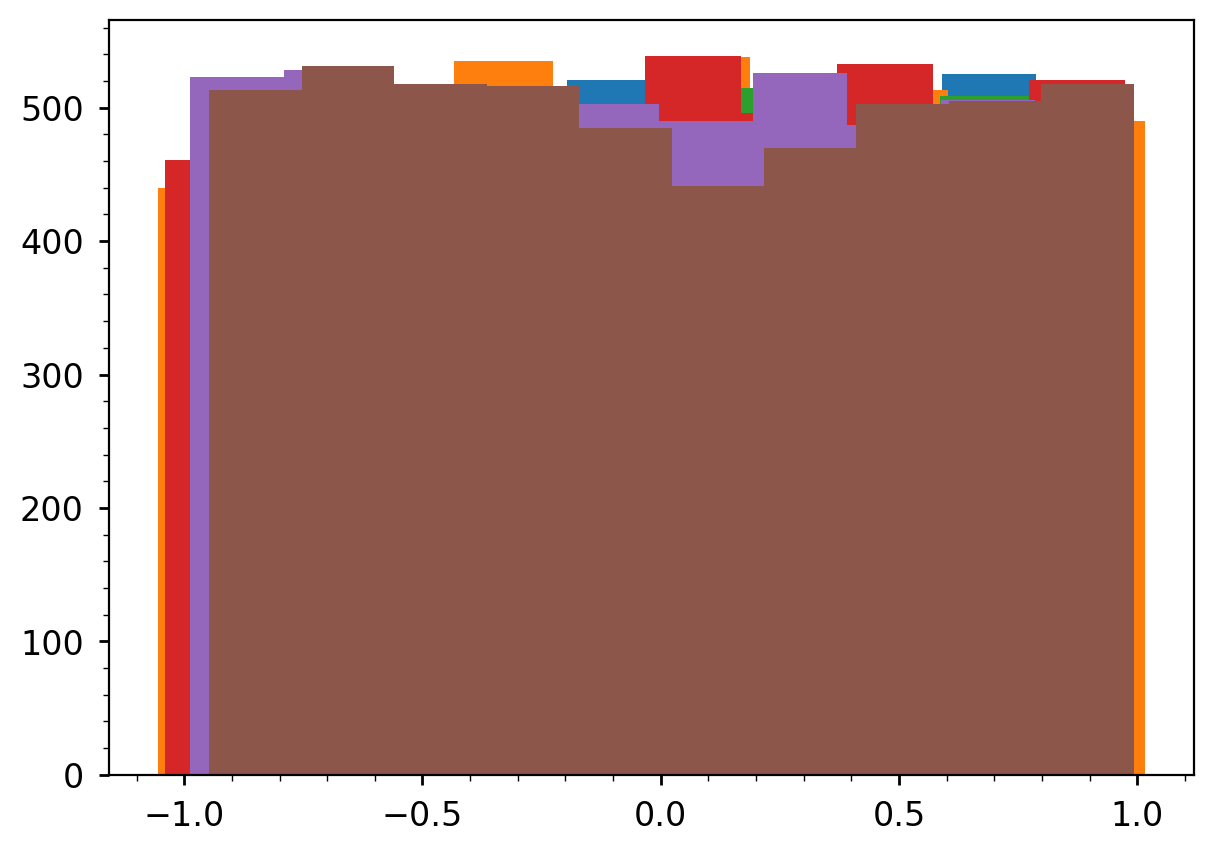

In [6]:
############# beautiful plot to make sure you actually normalized everything 
for i in range(Y_scaled.shape[1]):
    plt.hist(Y_scaled[:, i])
plt.show()

In [7]:
############# split train/test data 
split = 80
x_train, x_val, y_train, y_val = train_test_split(inputs_norm, Y_scaled, 
                                                test_size = (100 - split) / 100.,
                                                random_state = 42) 

x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], x_train.shape[2],1)
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1], x_val.shape[2],1)

In [8]:
print(x_train.shape)
print(x_val.shape)

(4000, 280, 280, 1)
(1000, 280, 280, 1)


## Model

In [9]:
model = Sequential() ## initial feed forward model 
model.add(Conv2D(32,kernel_size=5, input_shape=(x_train.shape[1:]),  kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
model.add(MaxPooling2D())
model.add(Conv2D(32,kernel_size=3, input_shape=(x_train.shape[1:]),  kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
model.add(MaxPooling2D())
#model.add(Conv2D(32,kernel_size=3, input_shape=(x_train.shape[1:]),  kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
#model.add(MaxPooling2D())
model.add(Flatten())     ## because outputs are scalar we need to flatten our conv layer 
model.add(Dropout(0.3))
model.add(Dense(1000))
model.add(Dense(100))
model.add(Dense(outputs.shape[1]))      ## add one fully connected or 'dense' layer with number of outputs desired
model.compile(optimizer='adam', loss='mean_squared_error') ## setup the optimizer and loss function
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 276, 276, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 138, 138, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 136, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 68, 68, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 147968)            0         
_________________________________________________________________
dropout (Dropout)            (None, 147968)            0         
_________________________________________________________________
dense (Dense)                (None, 1000)              1

In [10]:
n_epochs = 500
start = time.time()
hist = model.fit(x=x_train, y=y_train, 
                validation_data= (x_val, y_val),
                 batch_size = 64,
                 shuffle = 'true',
                 epochs = n_epochs,
                 verbose = 'false',
                 callbacks = [plot_losses])
end = time.time()
print('Time to train model: ' + str((end - start)/60) + ' minutes')

#model.save_weights('model_' + str(save_str) + 'n_epochs_' + str(n_epochs) +  '.h5')


Epoch 1/500


KeyboardInterrupt: 

<Figure size 1400x1000 with 0 Axes>

### Load trained model weights

start = time.time()
model.load_weights('small_model_weights.h5')
pred_outputs = model.predict(x_val)
end = time.time()
print('Time to load model and get new predictions: ' + str(np.round((end - start)/60, 5)) + ' minutes')

### Plot logloss 

In [ ]:
'''
plt.figure()
plt.loglog(hist.epoch, hist.history['val_loss'])
plt.loglog(hist.epoch, hist.history['loss'])
plt.show()
'''

### Plot loss 

In [ ]:
plt.figure()
plt.ylabel('error')
plt.xlabel('epochs')
plt.plot(hist.epoch, hist.history['val_loss'], label='test')
plt.plot(hist.epoch, hist.history['loss'], label='train')
plt.legend(loc='best')
plt.savefig(save_str + 'lossplot.png')
plt.show()

# Eval Model

In [ ]:
pred_outputs = model.predict(x_val)
print(pred_outputs.shape)
n_outputs = pred_outputs.shape[1]
print(n_outputs)

In [ ]:
r2s = []
for i in range(n_outputs):
    corr_matrix = np.corrcoef(pred_outputs[:,i], y_val[:,i])
    corr = corr_matrix[0,1]
    r2 = corr**2
    r2s.append(r2)
    print(r2)

In [ ]:

if(n_outputs==1):
    fig, axs = plt.subplots(1, n_outputs, figsize=(10, 10))
    axs.hexbin(pred_outputs[:,i], y_val[:,i], cmap = 'bone_r')
    axs.set_ylabel(labels[i] + ' validation')
    axs.set_xlabel(labels[i] + ' predicted')
    axs.set_title('R2: ' + str(np.round(r2s[i], 4)))
else: 
    fig, axs = plt.subplots(1, n_outputs, figsize=(15, 5))
    for i in range(n_outputs):
        axs[i].hexbin(pred_outputs[:,i], y_val[:,i], cmap = 'bone_r')
        axs[i].set_ylabel(labels[i] + ' validation')
        axs[i].set_xlabel(labels[i] + ' predicted')
        axs[i].set_title('R2: ' + str(np.round(r2s[i], 4)))

plt.savefig(save_str + 'predictions.png')
plt.show()